Visualizing the galaxy from the Magneticum simulation (trying out binning and contours).

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip

import matplotlib as mpl
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.mplot3d import Axes3D

import get_halpha_SB

%matplotlib inline
from matplotlib.colors import LogNorm
from matplotlib.colors import BoundaryNorm

# pick your machine
chinook=True
coho=False

In [3]:
if coho:
    data = np.loadtxt('/Users/deblokhorst/Desktop/disk_269_rot.ascii',dtype=float,skiprows=2)
if chinook:
    data = np.loadtxt('/Users/lokhorst/Desktop/disk_269_rot.ascii',dtype=float,skiprows=2)

In [4]:
data=data.T

In [5]:
x=data[0]
y=data[1]
z=data[2]
mass=data[3]

# set weights=mass * (L/M)
wt = mass

# once have dependance of M/L ratio on age, can use given ages of particles to make better estimates
MtoL = 7.

light = mass / 7.
#wt = light

# take into account dust blocking light from stars on far side?

Plot 2D histograms of the data - makes an image of their particle density.  Weight the 2D histogram by the masses of the particles.

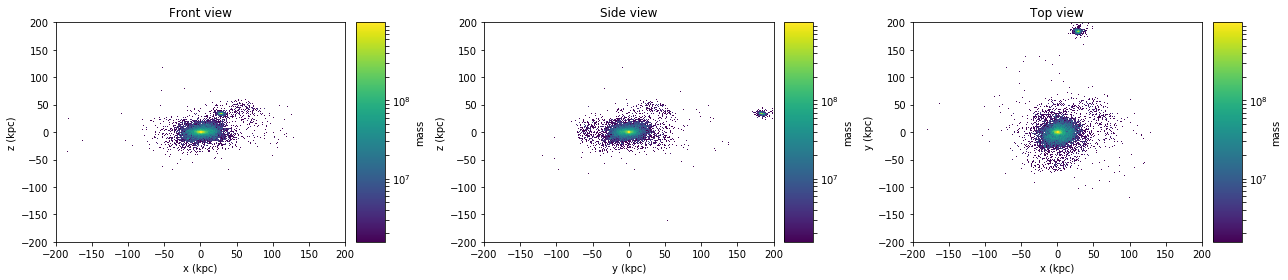

In [7]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(18, 4))
radius = 200
range = [[-1*radius, radius], [-1*radius, radius]]
H, xedges, yedges, xzplot = ax1.hist2d(x, z,weights=wt, bins=400,range = range, norm=LogNorm())
div = axgrid.make_axes_locatable(ax1)
cax = div.append_axes("right",size="10%",pad=0.15)
cbar = plt.colorbar(xzplot,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
cbar.ax.set_ylabel(r'%s' % ('mass'))
ax1.set_title('Front view')
ax1.set_xlabel('x (kpc)')
ax1.set_ylabel('z (kpc)')

H, xedges, yedges, yzplot = ax2.hist2d(y, z,weights=wt, bins=400,range = range, norm=LogNorm())
div = axgrid.make_axes_locatable(ax2)
cax = div.append_axes("right",size="10%",pad=0.15)
cbar = plt.colorbar(xzplot,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
cbar.ax.set_ylabel(r'%s' % ('mass'))
ax2.set_title('Side view')
ax2.set_xlabel('y (kpc)')
ax2.set_ylabel('z (kpc)')

H, xedges, yedges, xyplot = ax3.hist2d(x, y,weights=wt, bins=400,range = range, norm=LogNorm())
div = axgrid.make_axes_locatable(ax3)
cax = div.append_axes("right",size="10%",pad=0.15)
cbar = plt.colorbar(xzplot,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
cbar.ax.set_ylabel(r'%s' % ('mass'))
ax3.set_title('Top view')
ax3.set_xlabel('x (kpc)')
ax3.set_ylabel('y (kpc)')

plt.tight_layout()

A little bit fancier of a plot - have a bit more ease to control more features by making it an image and then plotting (like adding contours).

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


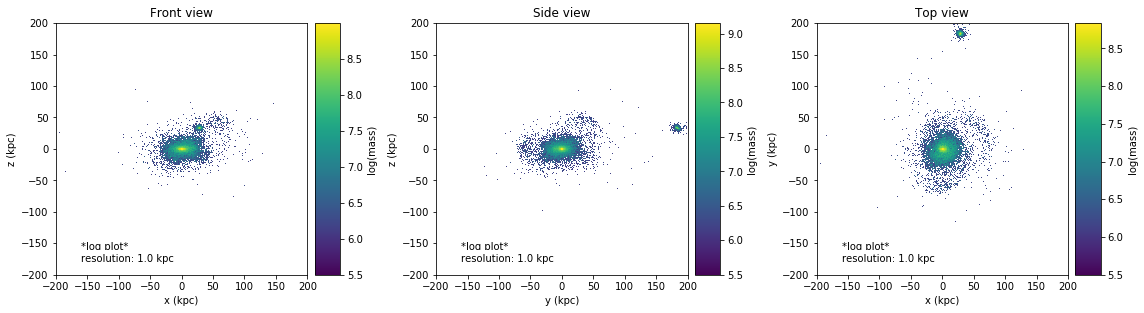

In [15]:
def makeimage(H,ax,radius,contour=False,log=True):
    #colmap = 'plasma'
    vmin=1; cbarlabel='mass'
    if log:
        H = np.log10(H)
        vmin=5.5
        plt.text(0.1,0.1,'*log plot*',transform=ax.transAxes,backgroundcolor='white')
        cbarlabel='log(mass)'
   
    img = ax.imshow(H.T,origin='lower',interpolation='nearest',vmin=vmin,extent=(-1*radius,radius,-1*radius,radius))#cmap=cm.get_cmap(colmap)
    cmap = cm.PRGn
    #if not log:
    img.cmap.set_under('white')  ## combined with vmin=1, makes 0 = white on plot
    if contour:
        ax.contour(H.T,[0.03e9,0.20e9,0.30e9],colors=['white','grey','black'],extent=(-1*radius,radius,-1*radius,radius))#,levels,colors=colours)#,cmap=cm.get_cmap(cmap, len(levels) - 1),)
    div = axgrid.make_axes_locatable(ax)
    cax = div.append_axes("right",size="10%",pad=0.1)
    cbar = plt.colorbar(img, cax=cax,orientation='vertical')#,extend='lower')
    cbar.solids.set_edgecolor("face")
    cbar.ax.set_ylabel(r'%s' % (cbarlabel))
    cbar.ax.tick_params()
    res= (radius*2.)/H.shape[0]
    plt.text(0.1,0.05,'resolution: %.1f kpc'%res,transform=ax.transAxes,backgroundcolor='white')

radius = 200
range = [[-1*radius, radius], [-1*radius, radius]]

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16, 6))
H, xedges, yedges = np.histogram2d(x, z, weights=wt, bins=400, range=range);
makeimage(H,ax1,radius)
H, xedges, yedges = np.histogram2d(y, z, weights=wt, bins=400, range=range);
makeimage(H,ax2,radius)
H, xedges, yedges = np.histogram2d(x, y, weights=wt, bins=400, range=range);
makeimage(H,ax3,radius)

ax1.set_title('Front view')
ax1.set_xlabel('x (kpc)')
ax1.set_ylabel('z (kpc)')
ax2.set_title('Side view')
ax2.set_xlabel('y (kpc)')
ax2.set_ylabel('z (kpc)')
ax3.set_title('Top view')
ax3.set_xlabel('x (kpc)')
ax3.set_ylabel('y (kpc)')

plt.tight_layout()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


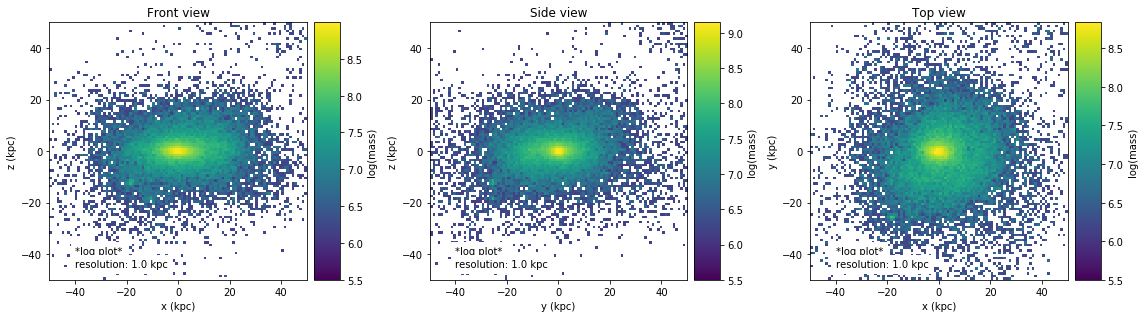

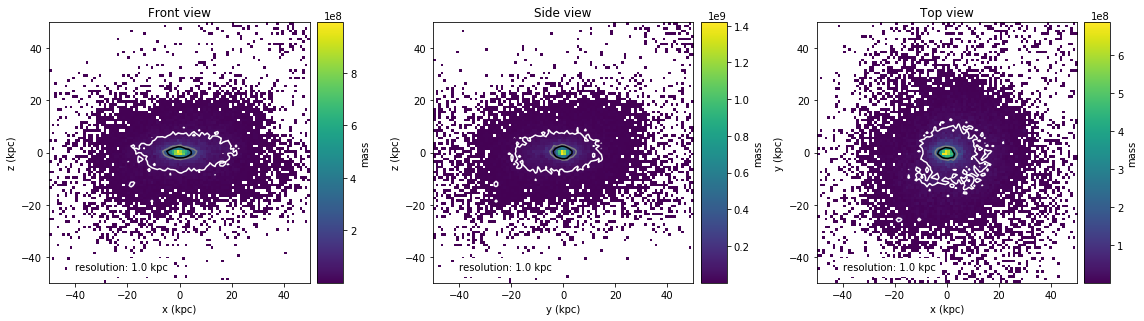

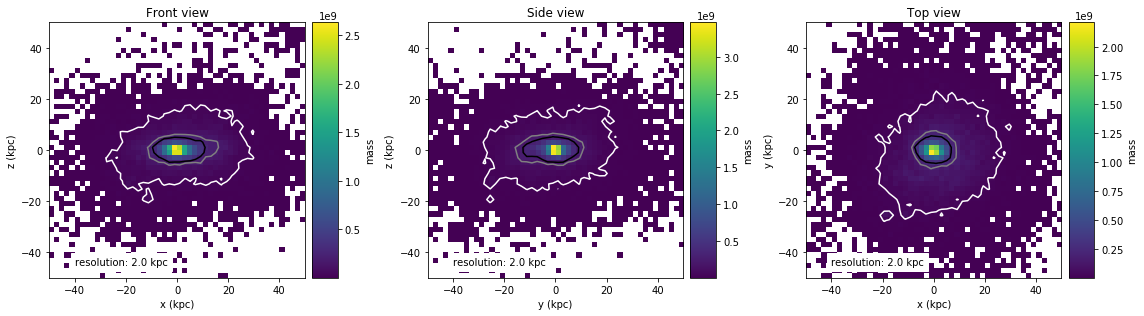

In [17]:
radius = 50

def plotzoom_2(radius,nbins=100,contours=True,log=True,contour=False):
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16, 6))
    condition = np.array(   (x < radius) & (x > -1*radius) &\
                        (y < radius) & (y > -1*radius) &\
                        (z < radius) & (z > -1*radius) \
                        )
    ii = np.array(np.where(condition)[0]) 
    range=[[-1*radius, radius], [-1*radius, radius]]
    
    H, xedges, yedges = np.histogram2d(x[ii], z[ii], weights=wt[ii], bins=nbins, range=range);
    #H, xedges, yedges, xzplot = ax.hist2d(x[ii], z[ii], bins=nbins, weights=wt[ii], range = [[-1*radius, radius], [-1*radius, radius]],norm=LogNorm())
    makeimage(H,ax1,radius,log=log,contour=contour)

    ax1.set_title('Front view')
    ax1.set_xlabel('x (kpc)')
    ax1.set_ylabel('z (kpc)')

    H, xedges, yedges = np.histogram2d(y[ii], z[ii], weights=wt[ii], bins=nbins, range=range);
    #H, xedges, yedges, yzplot = ax.hist2d(y[ii], z[ii], bins=nbins, weights=wt[ii], range = [[-1*radius, radius], [-1*radius, radius]],norm=LogNorm())
    makeimage(H,ax2,radius,log=log,contour=contour)

    ax2.set_title('Side view')
    ax2.set_xlabel('y (kpc)')
    ax2.set_ylabel('z (kpc)')

    H, xedges, yedges = np.histogram2d(x[ii], y[ii], weights=wt[ii], bins=nbins, range=range);
    #H, xedges, yedges, xyplot = ax.hist2d(x[ii], y[ii], bins=nbins, weights=wt[ii], range = [[-1*radius, radius], [-1*radius, radius]],norm=LogNorm())
    makeimage(H,ax3,radius,log=log,contour=contour)

    ax3.set_title('Top view')
    ax3.set_xlabel('x (kpc)')
    ax3.set_ylabel('y (kpc)')
    plt.tight_layout()
    return H

H = plotzoom_2(50)
H = plotzoom_2(50,log=False,contour=True)
H = plotzoom_2(50,nbins=50,log=False,contour=True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


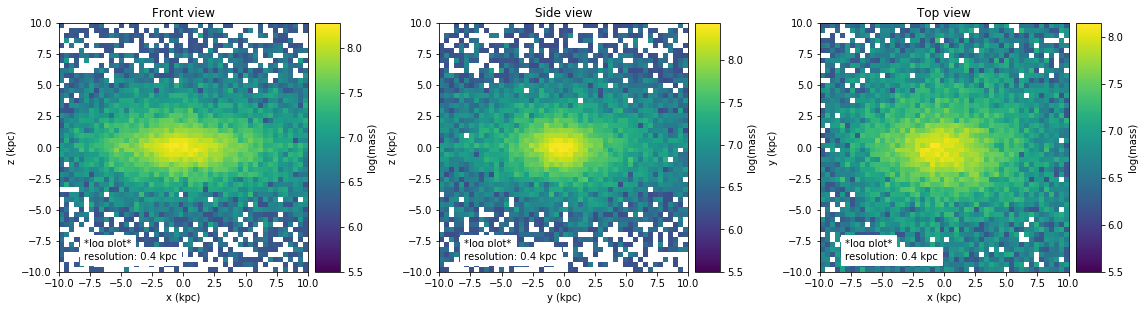

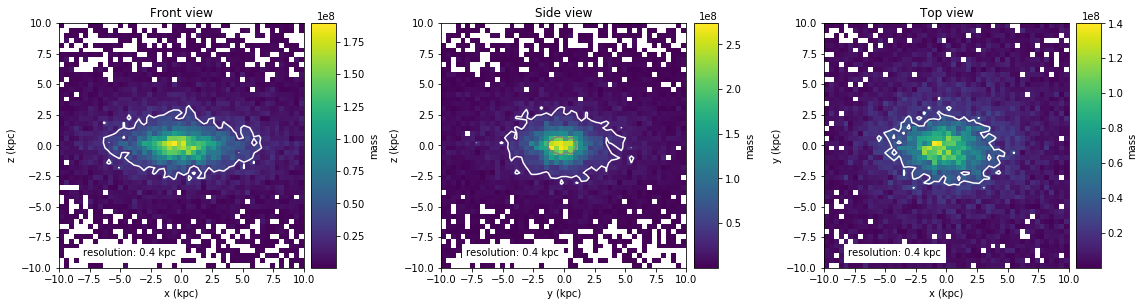

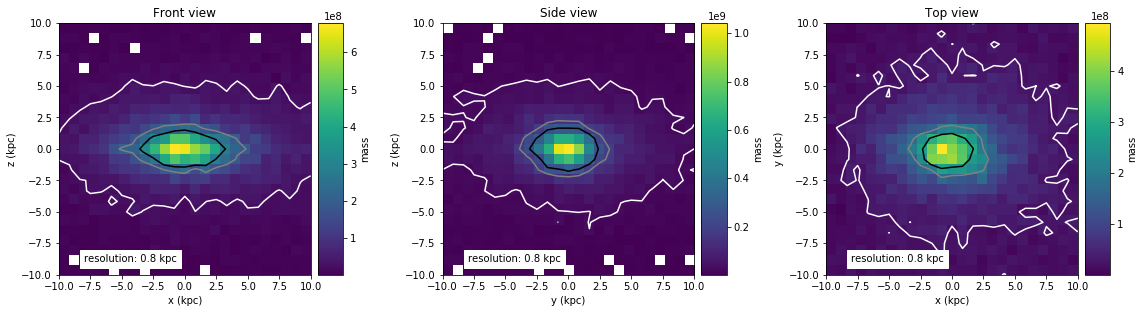

In [18]:
H = plotzoom_2(10,nbins=50)
H = plotzoom_2(10,nbins=50,log=False,contour=True)
H = plotzoom_2(10,nbins=25,log=False,contour=True)

TESTING NUMPY 2D HIST WEIGHTING

[[ 3.  0.  0.  0.  0.]
 [ 0.  3.  0.  0.  0.]
 [ 0.  0.  3.  0.  0.]
 [ 0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  3.]]
[-5. -3. -1.  1.  3.  5.]
[-5. -3. -1.  1.  3.  5.]


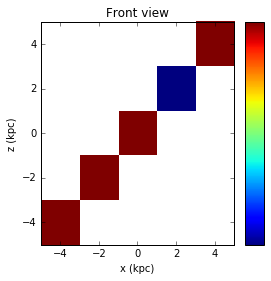

In [130]:
xt = [-5,-4,-3,-2,-1,0,1,2,3,4,5]#,6,7,8,9,10]
yt = [-5,-4,-3,-2,-1,0,1,2,3,4,5]#,6,7,8,9,10]
wt = [1,1,1,1,1,2,1,1,1,1,1]
wt = [ 1.5933E+06,1.5989E+06,1.5918E+06,1.6445E+06,1.6768E+06]#,1.5933E+06,1.5933E+06,1.5933E+06,1.5933E+06,1.5933E+06,1.5933E+06]
wt = [1,2,1,2,1,2,1,1,1,1,1]

fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))
radius = 5
range = [[-1*radius, radius], [-1*radius, radius]]
H, xedges, yedges, xzplot = ax1.hist2d(xt, yt, weights=wt,bins=5,range = range, norm=LogNorm())
div = axgrid.make_axes_locatable(ax1)
cax = div.append_axes("right",size="10%",pad=0.15)
cbar = plt.colorbar(xzplot,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
ax1.set_title('Front view')
ax1.set_xlabel('x (kpc)')
ax1.set_ylabel('z (kpc)')


print H
print xedges
print yedges

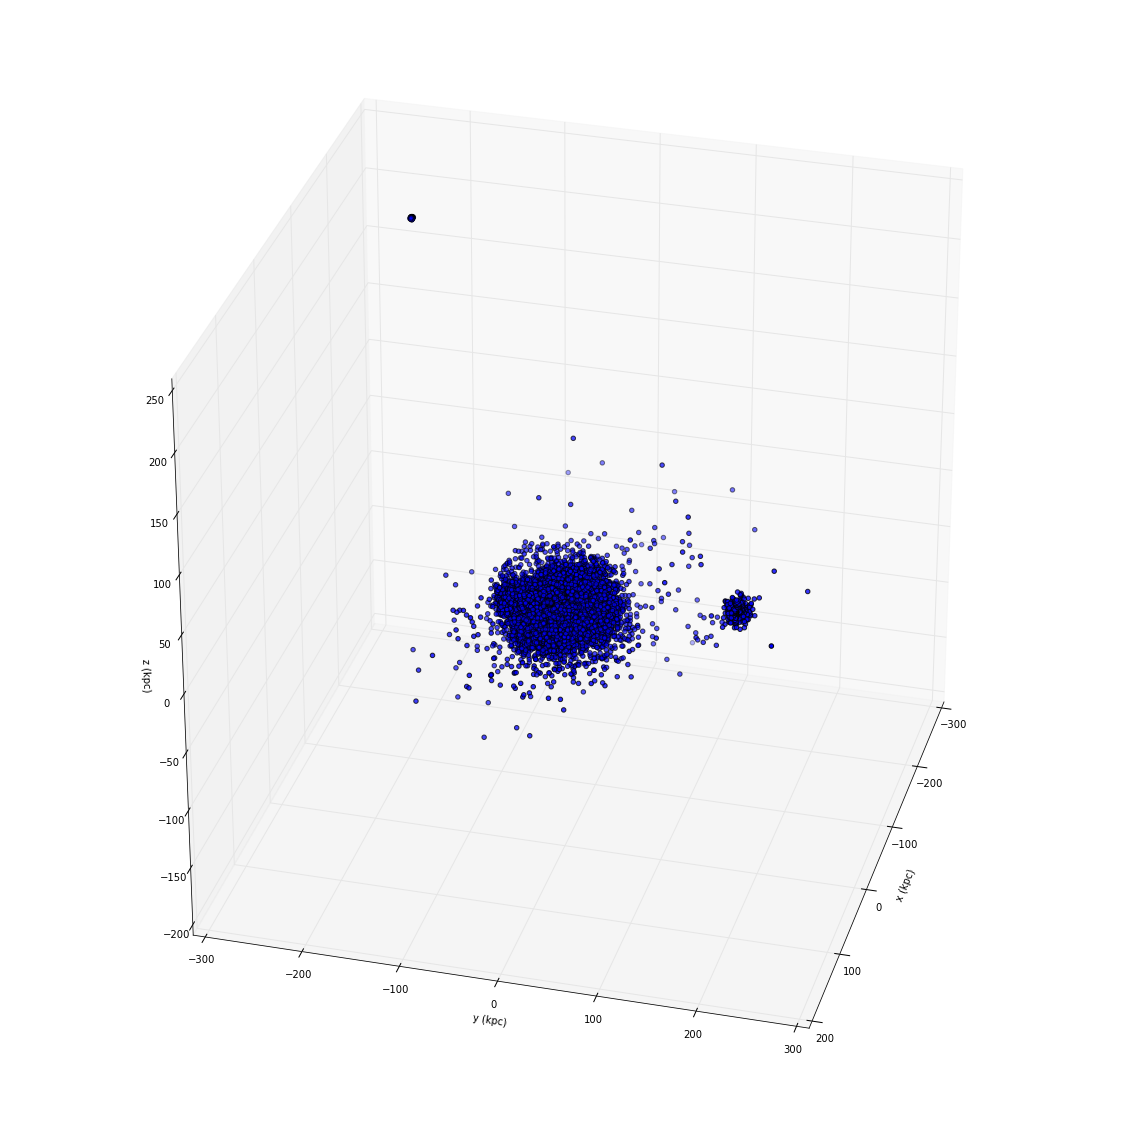

In [36]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z )
ax.set_xlabel('x (kpc)')
ax.set_ylabel('y (kpc)')
ax.set_zlabel('z (kpc)')
# rotate the axes and update
#for angle in range(0, 360):
ax.view_init(30, 15)

In [ ]:
radius = 50

def plotzoom_2dhist(radius,nbins=100,contours=True):
    ''' Cant get the contours to work quite right with this one. Using other version with image.'''
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(16, 6))
    condition = np.array(   (x < radius) & (x > -1*radius) &\
                        (y < radius) & (y > -1*radius) &\
                        (z < radius) & (z > -1*radius) \
                        )
    ii = np.array(np.where(condition)[0]) 

    H, xedges, yedges, xzplot = ax1.hist2d(x[ii], z[ii], bins=nbins, norm=LogNorm())
        # plot contours
    if contours:
        #cmap = cm.PRGn
        ax1.contour(H.T,levels=(0,10,20,30,40,50,60,70,80))#,levels,colors=colours)#,cmap=cm.get_cmap(cmap, len(levels) - 1),)
    div = axgrid.make_axes_locatable(ax1)
    cax = div.append_axes("right",size="10%",pad=0.15)
    cbar = plt.colorbar(xzplot,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
    ax1.set_title('Front view')
    ax1.set_xlabel('x (kpc)')
    ax1.set_ylabel('z (kpc)')

    H, xedges, yedges, yzplot = ax2.hist2d(y[ii], z[ii], bins=nbins, norm=LogNorm())
    div = axgrid.make_axes_locatable(ax2)
    cax = div.append_axes("right",size="10%",pad=0.15)
    cbar = plt.colorbar(xzplot,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
    ax2.set_title('Side view')
    ax2.set_xlabel('y (kpc)')
    ax2.set_ylabel('z (kpc)')

    H, xedges, yedges, xyplot = ax3.hist2d(x[ii], y[ii], bins=nbins, norm=LogNorm())
    div = axgrid.make_axes_locatable(ax3)
    cax = div.append_axes("right",size="10%",pad=0.15)
    cbar = plt.colorbar(xzplot,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
    ax3.set_title('Top view')
    ax3.set_xlabel('x (kpc)')
    ax3.set_ylabel('y (kpc)')
    return H

H = plotzoom_2dhist(50)
#plotzoom(20)
H = plotzoom_2dhist(10,nbins=50)

plt.tight_layout()